In [1]:

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
import numpy as np
import mimetypes
import argparse
import imutils
import pickle
import cv2
import os
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt


### Model importation

In [2]:

model = load_model("Data_Signs_model_creation/signs_classification_operationel")

### Create the label dictionnary

In [3]:
classe = { 0:'Vitesse limite (20km/h)',
            1:'Vitesse limite (30km/h)', 
            2:'Vitesse limite (50km/h)', 
            3:'Vitesse limite (60km/h)', 
            4:'Vitesse limite (70km/h)', 
            5:'Vitesse limite (80km/h)', 
            6:'Fin de limite de vitesse (80km/h)', 
            7:'Vitesse limite (100km/h)', 
            8:'Vitesse limite (120km/h)', 
            9:'Dépassement interdit sauf 2 roues', 
            10:'Dépassement interdit pour >3.5t', 
            11:'Priorité à droite à l\'intersection', 
            12:'Route prioritaire', 
            13:'Cedez le passage', 
            14:'Stop', 
            15:'Interdit aux véhicules', 
            16:'Veh >3.5t interdits', 
            17:'Sens interdit', 
            18:'Panneau danger', 
            19:'Virage dangereux à gauche', 
            20:'Virage dangereux à droite', 
            21:'Succession de virages', 
            22:'Cassis ou dos-d\'ânes', 
            23:'Route glissante', 
            24:'Chaussée rétrécie par la droite', 
            25:'Travaux', 
            26:'Feux tricolore', 
            27:'Passage piéton', 
            28:'Attention enfants', 
            29:'Attention vélos', 
            30:'Attention neige/verglas',
            31:'Passage animaux sauvages', 
            32:'Fin de toutes interdictions', 
            33:'Direction obligatoire à droite', 
            34:'Direction obligatoire à gauche', 
            35:'Direction obligatoire tout droit', 
            36:'Direction obligatoire tout droit ou à droite', 
            37:'Direction obligatoire tout droit ou gauche', 
            38:'Contournement obligatoire par la droite', 
            39:'Contournement obligatoire par la gauche', 
            40:'Giratoire', 
            41:'Fin de l\'interdiction de dépassement', 
            42:'Fin de l\'interdiction de dépassement >3.5t' }

### Create infherence functions

In [4]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [5]:

def get_prediction_image(image,shape):

  #define new image shape
  newHeight = shape
  newWidth = int(image.shape[1]*shape/image.shape[0])
  image = cv2.resize(image, (newWidth, newHeight)) 

  #Process cv2 selective search
  cv2.setUseOptimized(True)
  cv2.setNumThreads(8)
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  ss.setBaseImage(image)
  ss.switchToSelectiveSearchFast()
  rects = ss.process()

  proposals = []
  boxes = []
  # loop over the region proposal bounding box coordinates generated by
  # running selective search
  for (x, y, w, h) in rects[:800]:

    if w<h*1.3 and h<w*1.3:
      # extract the region from the input image, convert it from BGR to
      # RGB channel ordering, and then resize it to the required input
      # dimensions of our trained CNN
      roi = image[y:y + h, x:x + w]
      roi = cv2.resize(roi, (50,50),
        interpolation=cv2.INTER_CUBIC)
      roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
      # further preprocess the ROI
      roi = img_to_array(roi)
      roi = roi.astype('float')/255
      # update our proposals and bounding boxes lists
      
      proposals.append(roi)
      boxes.append((x, y, x + w, y + h))

  # clone the original image so that we can draw on it

  clone = image.copy()
  proposals = np.array(proposals, dtype="float32")
  boxes = np.array(boxes, dtype="int32")
  


  # Predict classes of the boxes
  if len(proposals)>0:
    proba = model.predict(proposals)
    labels=model.predict_classes(proposals)
    idxs=[]
    idx=0
    for pro in proba:
      scores = pro[5:]
      # Getting index of the class with the maximum value of probability
      class_current = np.argmax(scores)
      # Getting value of probability for defined class
      confidence_current = scores[class_current]
      # If confidence > 95% and class is not "no_signs", append the label to the boxes
      if confidence_current>0.95 and labels[idx] !=43:
        idxs.append(idx)
      idx=idx+1

    boxes=boxes[idxs]
    labels=labels[idxs]
    proba=proba[idxs]
    proposals=proposals[idxs]


  # loop over the bounding boxes and associated probabilities
  idx=0
  displayedBoxes=[]
  for (box) in boxes:
    # draw the bounding box, label, and probability on the image
    # calculate the iou and display or not the boxes
    (startX, startY, endX, endY) = box
    try:
      if len(displayedBoxes)>0:
        for boxB in displayedBoxes:
          iou=bb_intersection_over_union(boxB, box)
          if iou > 0.5:
            idx=idx+1
          elif iou==0:
            iou=bb_intersection_over_union(box,boxB)
            if iou > 0.5:
              idx=idx+1   
            else:
              displayedBoxes.append(box)
              y = startY - 10 if startY - 10 > 10 else startY + 10
              cv2.putText(clone, classe[(labels[idx])], (startX, y), cv2.FONT_HERSHEY_SIMPLEX,
              0.65, (0, 255, 0), 2)
              cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
              idx=idx+1
          else:
            displayedBoxes.append(box)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.putText(clone, classe[(labels[idx])], (startX, y), cv2.FONT_HERSHEY_SIMPLEX,
            0.65, (0, 255, 0), 2)
            cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
            idx=idx+1
      else:
        displayedBoxes.append(box)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(clone, classe[(labels[idx])], (startX, y), cv2.FONT_HERSHEY_SIMPLEX,
        0.65, (0, 255, 0), 2)
        cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
        idx=idx+1
    except:
      pass

  
  return clone,labels



### Start the inference on pictures

(200, 246, 3)

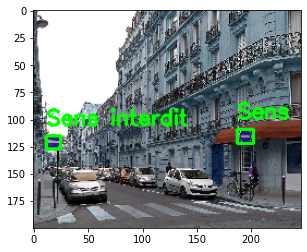

In [6]:
img=cv2.imread('testData/test6.jpg')
img,labels=get_prediction_image(img,200)
plt.imshow(img)
img.shape

In [7]:
### Inference for videos

In [8]:

cap = cv2.VideoCapture("testData/test11.mp4")

width= int(cap.get(3))
height=int(cap.get(4))
newHeight= 800
newWidth = int(width*newHeight/height)


out= cv2.VideoWriter('test_record.avi', cv2.VideoWriter_fourcc(*'MJPG'), 20, (newWidth,newHeight))


while(cap.isOpened()):
    ret, frame = cap.read()

    if ret==True:
        frame =cv2.addWeighted(frame, 1.5, np.zeros(frame.shape, frame.dtype), 0, 0)
        frame,labels=get_prediction_image(frame,200)
        frame = cv2.resize(frame, (newWidth, newHeight),
            interpolation=cv2.INTER_CUBIC) 
        out.write(frame)
        cv2.imshow('frame',frame)
    else:
        break

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


print('end')
# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()

end
